In [2]:
# add modules to Python's search path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


import numpy as np
import matplotlib.pyplot as plt

#import  torch
#from geomloss import SamplesLoss
import tensorflow as tf
from modules import wasserstein as tfw
import tensorflow_probability as tfp
import scipy as sp
from sklearn import preprocessing

In [2]:
"""
use_cuda = torch.cuda.is_available()
# N.B.: We use float64 numbers to get nice limits when blur -> +infinity
dtype    = torch.cuda.DoubleTensor if use_cuda else torch.DoubleTensor

# make a convenient wrapper for producing samples in form of a tensor
def torch_sampler(mean, cov, size):
    samples = np.random.multivariate_normal(mean, cov, size)
    return torch.from_numpy(samples)

# set up parameters for our two test distributions
dimension = 3
mean_1 = np.zeros(dimension)
mean_2 = mean_1 + 0.1 * np.ones(dimension)
cov_1 = np.identity(dimension)
cov_2 = cov_1

# finally create the samplers our test distributions
sampler_1 = lambda size: torch_sampler(mean_1, cov_1, size)
sampler_2 = lambda size: torch_sampler(mean_2, cov_2, size)

# test our samplers
print("samples from distribution #1:\n{}".format(sampler_1(3)))
print("samples from distribution #2:\n{}".format(sampler_2(3)))
"""

'\nuse_cuda = torch.cuda.is_available()\n# N.B.: We use float64 numbers to get nice limits when blur -> +infinity\ndtype    = torch.cuda.DoubleTensor if use_cuda else torch.DoubleTensor\n\n# make a convenient wrapper for producing samples in form of a tensor\ndef torch_sampler(mean, cov, size):\n    samples = np.random.multivariate_normal(mean, cov, size)\n    return torch.from_numpy(samples)\n\n# set up parameters for our two test distributions\ndimension = 3\nmean_1 = np.zeros(dimension)\nmean_2 = mean_1 + 0.1 * np.ones(dimension)\ncov_1 = np.identity(dimension)\ncov_2 = cov_1\n\n# finally create the samplers our test distributions\nsampler_1 = lambda size: torch_sampler(mean_1, cov_1, size)\nsampler_2 = lambda size: torch_sampler(mean_2, cov_2, size)\n\n# test our samplers\nprint("samples from distribution #1:\n{}".format(sampler_1(3)))\nprint("samples from distribution #2:\n{}".format(sampler_2(3)))\n'

In [3]:
"""
num_samples_1 = 500
num_samples_2 = 500
samples_1 = sampler_1(num_samples_1)
samples_2 = sampler_2(num_samples_2)
loss = SamplesLoss("sinkhorn", p=2, blur=0.01, scaling=.99, backend="online")
print(np.sqrt(loss(samples_1, samples_2).item()))
"""

'\nnum_samples_1 = 500\nnum_samples_2 = 500\nsamples_1 = sampler_1(num_samples_1)\nsamples_2 = sampler_2(num_samples_2)\nloss = SamplesLoss("sinkhorn", p=2, blur=0.01, scaling=.99, backend="online")\nprint(np.sqrt(loss(samples_1, samples_2).item()))\n'

In [44]:
# make a convenient wrapper for producing samples in form of a tensor
def tf_sampler(mean, cov, size):
    samples = np.random.multivariate_normal(mean, cov, size)
    return tf.convert_to_tensor(samples, dtype=tf.float32)

# set up parameters for our two test distributions
dimension = 10
mean_1 = np.zeros(dimension)
mean_2 = mean_1 + 10.0 
cov_1 = 0.1 * np.identity(dimension)
cov_2 = 100. * cov_1

# finally create the samplers our test distributions
sampler_1 = lambda size: tf_sampler(mean_1, cov_1, size)
sampler_2 = lambda size: tf_sampler(mean_2, cov_2, size)

# test our samplers
#print("samples from distribution #1:\n{}".format(sampler_1(3)))
#print("samples from distribution #2:\n{}".format(sampler_2(3)))

# Wasserstein_2 formula
def w2_formula(ensemble_1, ensemble_2, tf=True):
    if tf:
        ensemble_1 = ensemble_1.numpy()
        ensemble_2 = ensemble_2.numpy()
    m1 = np.mean(ensemble_1, axis=0)
    m2 = np.mean(ensemble_2, axis=0)
    C1 = np.cov(ensemble_1.T)
    C2 = np.cov(ensemble_2.T)
    r_C2 = sp.linalg.sqrtm(C2)
    term_1 = np.linalg.norm(m1 - m2, ord=2)
    term_2 = np.trace( C1 + C2 - 2.0 * sp.linalg.sqrtm(np.linalg.multi_dot([r_C2, C1, r_C2])) )
    return np.sqrt(term_1**2 + term_2**2)

def exact_w2(m1, m2, C1, C2):
    term_1 = np.linalg.norm(m1 - m2, ord=2)
    r_C2 = sp.linalg.sqrtm(C2)
    term_2 = np.trace( C1 + C2 - 2.0 * sp.linalg.sqrtm(np.linalg.multi_dot([r_C2, C1, r_C2])) )
    return np.sqrt(term_1**2 + term_2**2)

In [45]:
num_samples_1 = 200
num_samples_2 = 2000
samples_1 = sampler_1(num_samples_1)
samples_2 = sampler_2(num_samples_2)
#print(np.mean(samples_1, axis=0))
#print(np.mean(samples_2, axis=0))
loss = tfw.sinkhorn_loss(samples_1, samples_2, epsilon=0.01, num_iters=50, p=2)
print("Wasserstein_2, computed with Sinkhorn algorithm: {}".format(np.sqrt(loss)))
print("Wasserstein_2, computed with formula: {}".format(exact_w2(mean_1, mean_2, cov_1, cov_2)))

Wasserstein_2, computed with Sinkhorn algorithm: 9.29254150390625
Wasserstein_2, computed with formula: 80.99999999999999


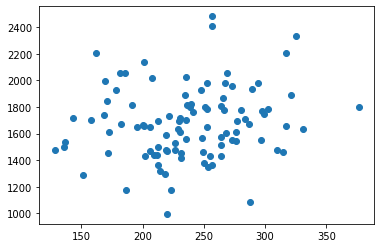

In [66]:
def generate_sampler(dim=10, mean_a=-100., mean_b=100., cov_a=-10., cov_b=10.):
    A = np.random.uniform(cov_a, cov_b, size=(dim, dim))
    cov = np.dot(A.T, A)
    mean = np.random.uniform(mean_a, mean_b, size=dim)
    return mean, cov, lambda size: tf_sampler(mean, cov, size)


num_exps = 100
dim = 10
num_samples = 1500
w_s = np.zeros(num_exps)
w_f = np.zeros(num_exps)
for i in range(num_exps):
    print('Working on iteration #{}'.format(i), end='\r')
    mean_1, cov_1, sampler_1 = generate_sampler(dim=dim)
    mean_2, cov_2, sampler_2 = generate_sampler(dim=dim)
    samples_1 = sampler_1(num_samples)
    samples_2 = sampler_2(num_samples)
    w_s[i] = np.sqrt(tfw.sinkhorn_loss(samples_1, samples_2, epsilon=0.01, num_iters=50, p=2))
    w_f[i] = exact_w2(mean_1, mean_2, cov_1, cov_2) 

plt.scatter(w_s, w_f)
plt.show()